In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import os 
import json
from langdetect import detect
import re
import string
import csv
import community 

In [2]:
os.chdir("C://Users//megha//Downloads//Social Networks//Assignment 2//data//Reddit")

In [3]:
#Loading the previously stored data

with open("reddit_ts.json", 'r') as json_file:
    reddit_data_ts = json.load(json_file)
    

with open("reddit_bp.json", 'r') as json_file:
    reddit_data_bp = json.load(json_file)

In [4]:
reddit_data_ts = {"submissions": reddit_data_ts}

The data for both Talylor Swift and BlackPink consisted of a range of titles with huge scores. For the graph, we decided to take only those titles where score is greater than 0.  

In [5]:
filtered_data_ts_reddit = {
    'submissions': [
        submission for submission in reddit_data_ts['submissions'] if (
            submission['score'] > 300 
        )
    ]
}

filtered_data_bp_reddit = {
    'submissions': [
        submission for submission in reddit_data_bp['submissions'] if (
            submission['score'] > 300 
        )
    ]
}

In [6]:
# Function to visualize the top 10 titles with score above than 300 wit highest comments for both the artists.

def comment_title_count(data_dict): 
    comment_counts = []

    for submission in data_dict['submissions']:
        title = submission['title']
        comments = submission['comments']

        # Check if comments exist and count them
        if comments is not None:
            comment_count = len(comments)
        else:
            comment_count = 0

        comment_counts.append((title, comment_count))

    len(comment_counts)
    
    # Sort comment_counts in descending order by comment counts
    comment_counts.sort(key=lambda x: x[1], reverse=True)

    # Extract the top 10 titles and comment counts
    top_10_titles = [entry[0] for entry in comment_counts[:10]]
    top_10_comment_counts = [entry[1] for entry in comment_counts[:10]]

    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(15, 6))

    # Create a horizontal bar chart for the top 10 titles
    ax.barh(top_10_titles, top_10_comment_counts, color='skyblue')

    # Set y-axis labels and title
    ax.set_yticklabels(top_10_titles, fontsize=10)
    ax.set_xlabel('Number of Comments')
    ax.set_ylabel('Top 10 Titles')
    ax.set_title('Top 10 Titles with the Highest Number of Comments - Taylor Swift')

    # Add data labels to the right of the bars
    for i, count in enumerate(top_10_comment_counts):
        ax.text(count + 5, i, str(count), va='center')

    # Adjust spacing for y-axis labels
    plt.tight_layout()

    # Show the plot
    plt.show()




<ipython-input-6-8647092c73c3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_10_titles, fontsize=10)


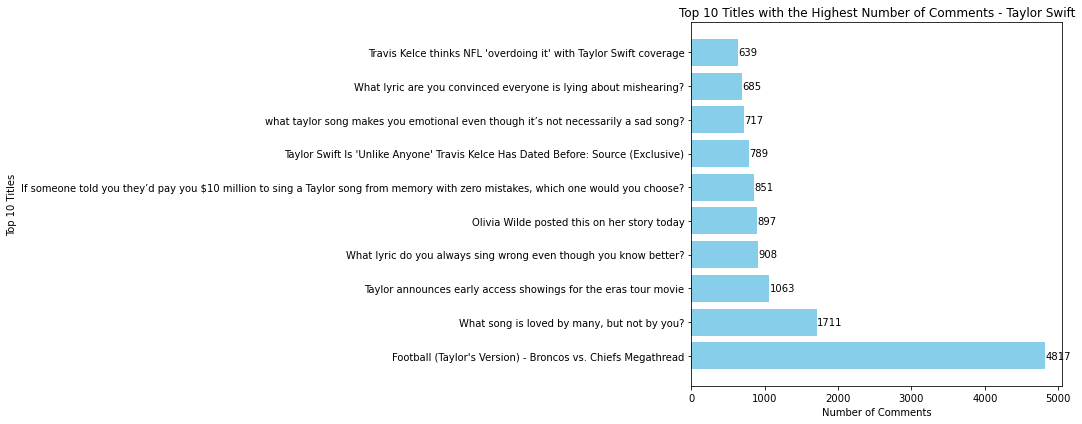

In [7]:
comment_title_count(filtered_data_ts_reddit)

<ipython-input-6-8647092c73c3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_10_titles, fontsize=10)


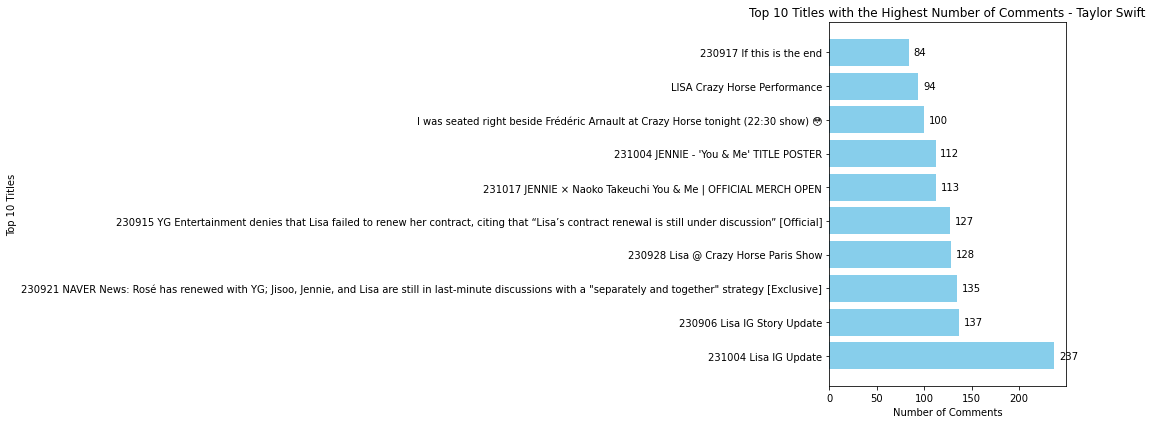

In [8]:
comment_title_count(filtered_data_bp_reddit)

## Creating graphs for reddit data

In [9]:
# Function to create graphs for the data

def dir_graph_reddit(reddit_data, sFileName, csv_file):

    # Construct directed graph
    replyGraph = nx.DiGraph()

    # Dictionary to track the ids of submissions and posts
    dSubCommentId1 = {}

    for submission in reddit_data["submissions"]:
        submission_author = submission["author"]

        if submission["comments"] is not None:

            # Check if the submission author node exists, and add it if not
            if submission_author not in replyGraph:
                replyGraph.add_node(submission_author, subNum=1, color='blue', size=30)  

            submissionId = submission["submission_id"]
            dSubCommentId1[submissionId] = {submissionId: submission_author}

            for comment in submission["comments"]:
                comment_author = comment["author"]

                if comment_author != 'ExternalUserError':
                    dSubCommentId1[submissionId].update({comment_author: comment_author})

                    # Ensure that both the source and target nodes exist before adding edges
                    if comment_author not in replyGraph:
                        replyGraph.add_node(comment_author, subNum=0, color='red')  # Set size to 30 for comment author

                    if dSubCommentId1[submissionId][comment_author] not in replyGraph:
                        replyGraph.add_node(dSubCommentId1[submissionId][comment_author], subNum=0, color='green', size=30)  # Set size to 30 for replies

                    # Add an edge between the comment author and the title submission author
                    replyGraph.add_edge(comment_author, submission_author, replyNum=1)
                    
        
    # Identify isolated nodes
    isolated_nodes = list(nx.isolates(replyGraph))

    # Remove isolated nodes from the graph
    replyGraph.remove_nodes_from(isolated_nodes)

    #
    nx.readwrite.write_graphml(replyGraph, sFileName)
        
    # Extract the node labels (Reddit usernames) from replyGraph
    node_labels = list(replyGraph.nodes())

    # Write the labels to a CSV file
    with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write the node labels
        for label in node_labels:
            writer.writerow([label])
                
    return replyGraph


In [10]:
#Calling the function and creating the graph

replyGraph_ts_reddit = dir_graph_reddit(filtered_data_ts_reddit, "reddit_ts.graphml", 'ground_truth_labels_ts.csv')

In [11]:
replyGraph_bp_reddit = dir_graph_reddit(filtered_data_bp_reddit, "reddit_bp.graphml", "ground_truth_labels_bp.csv")

## Computing centrality

In [12]:
def compute_centrality(replyGraph):

    lDegCentrality = nx.degree_centrality(replyGraph)
    lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph, max_iter=500)
    lKatzCentrality = nx.katz_centrality(replyGraph)
    

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Customize the appearance of each histogram
    titles = ['Degree', 'Eigenvector', 'Katz']
    centrality_measures = [list(lDegCentrality.values()), list(lEigenVectorCentrality.values()), list(lKatzCentrality.values())]
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    for i, ax in enumerate(axes):
        ax.hist(centrality_measures[i], bins=20, color=colors[i], edgecolor='black')
        ax.set_title(titles[i])
        ax.set_xlabel('Centrality')
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


    return lDegCentrality, lEigenVectorCentrality, lKatzCentrality

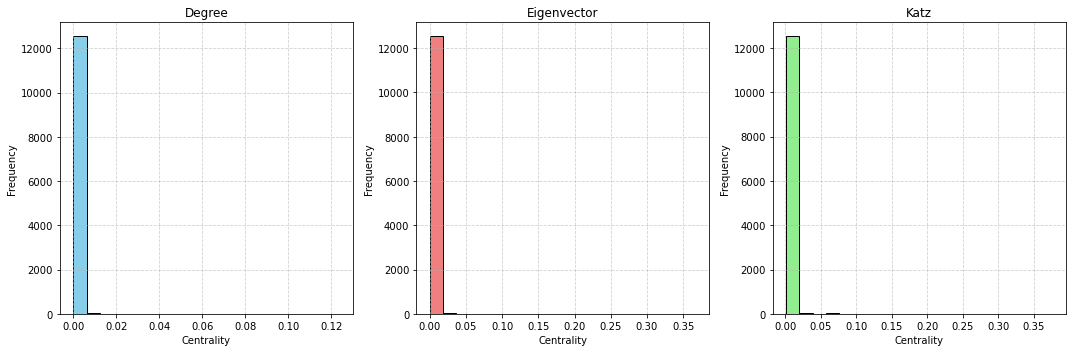

In [13]:
lDegCentrality_ts_reddit, lEigenVectorCentrality_ts_reddit, lKatzCentrality_ts_reddit = compute_centrality(replyGraph_ts_reddit)

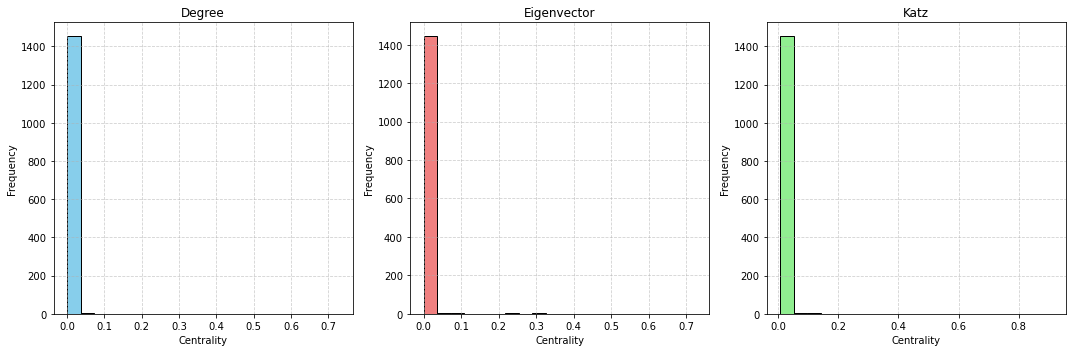

In [14]:
lDegCentrality_bp_reddit, lEigenVectorCentrality_bp_reddit, lKatzCentrality_bp_reddit = compute_centrality(replyGraph_bp_reddit)

In [15]:
def update_centrality_attributes(lDegCentrality, lEigenVectorCentrality, lKatzCentrality, replyGraph, sFileName):

    # eigenvector centrality, stored in node attribute 'eigen'
    for nodeId, cent in lDegCentrality.items():
        replyGraph.nodes[nodeId]['eigen'] = float(cent)

    # eigenvector centrality, stored in node attribute 'eigen'
    for nodeId, cent in lEigenVectorCentrality.items():
        replyGraph.nodes[nodeId]['eigen'] = float(cent)

    # katz centrality, stored in node attribute 'katz'
    for nodeId, cent in lKatzCentrality.items():
        replyGraph.nodes[nodeId]['katz'] = float(cent)
        
    print('Global clustering coefficient/transitivit = {}'.format(nx.transitivity(replyGraph)))
    print('number of strongly connected components = {}'.format(nx.number_strongly_connected_components(replyGraph)))
    print('number of weakly connected components = {}'.format(nx.number_weakly_connected_components(replyGraph)))
    
    nx.readwrite.write_graphml(replyGraph, 'mod' + sFileName, infer_numeric_types=True)
    
    return replyGraph

In [16]:
replyGraph_ts_reddit = update_centrality_attributes(lDegCentrality_ts_reddit, lEigenVectorCentrality_ts_reddit, 
                                                    lKatzCentrality_ts_reddit, replyGraph_ts_reddit, "reddit_ts.graphml")

Global clustering coefficient/transitivit = 0.0895039135086435
number of strongly connected components = 12564
number of weakly connected components = 1


In [17]:
replyGraph_bp_reddit = update_centrality_attributes(lDegCentrality_bp_reddit, lEigenVectorCentrality_bp_reddit, 
                                                    lKatzCentrality_bp_reddit, replyGraph_bp_reddit, "reddit_bp.graphml")

Global clustering coefficient/transitivit = 0.1949367088607595
number of strongly connected components = 1456
number of weakly connected components = 1


##  Louvain Community Detection

In [18]:
# def purity(comm1, groundTruthComm):

#     # set overlap
#     overlapTotal = 0
    
#     for setComm1 in comm1:
        
#         lOverlap = [len(setComm1 & setComm2) for setComm2 in groundTruthComm]
        
#         maxOverlap = max(lOverlap)
#         overlapTotal += maxOverlap


#     return overlapTotal / sum([len(comm) for comm in comm1])
    

In [19]:
def purity(comm1, groundTruthComm):
    """
    Calculate the purity score for a community against ground truth.

    @param comm1: Community to evaluate (list of set format)
    @param groundTruthComm: Ground truth to compare against (list of set format)
    @return: Purity score, between 0 to 1
    """
    if not comm1:
        # Return 0 purity if comm1 is empty
        return 0

    # Initialize overlapTotal
    overlapTotal = 0

    # Loop through each community in comm1 and find the overlap with each
    # of the communities in groundTruthComm. Take the one with the maximum
    # overlap and add it to the running total (overlapTotal).
    for setComm1 in comm1:
        # Calculate overlap with each ground truth community
        lOverlap = [len(setComm1 & setComm2) for setComm2 in groundTruthComm]
        # Find the max overlap
        maxOverlap = max(lOverlap)
        overlapTotal += maxOverlap

    # Normalize the overlapTotal to compute purity
    return overlapTotal / sum([len(comm) for comm in comm1])


In [20]:
def dictToSetFormat(dComms, maxCommNum):


    lGroundTruth = [set() for x in range(maxCommNum)]
    
    for (name, clusId) in dComms.items():
        lGroundTruth[clusId].add(name)

    return lGroundTruth

In [21]:
def louvaincommunity(replyGraph, sFileName, ground_truth_file):
    
    k = 3
    lCpmComms = list(nx.algorithms.community.k_clique_communities(nx.to_undirected(replyGraph), k))
    
    dLouvainComms = community.best_partition(nx.to_undirected(replyGraph))
    
    louvanCommNum = max([y for (x,y) in dLouvainComms.items()]) + 1
    lLouvainComms = dictToSetFormat(dLouvainComms, louvanCommNum)
    
    # cpm labels, stored in node attribute 'cpmClusId'
    for clusId, lComms in enumerate(lCpmComms):
        for nodeId in lComms:
            replyGraph.nodes[nodeId]['cpmClusId'] = clusId

    # louvain labels, stored in node attribute 'louvain'
    for clusId, lComms in enumerate(lLouvainComms):
        for nodeId in lComms:
            replyGraph.nodes[nodeId]['louvain'] = clusId
            
    
    nx.readwrite.write_graphml(replyGraph, 'mod2' + sFileName, infer_numeric_types=True)
    
    lGroundTruth = []
    
    with open(ground_truth_file, 'r', encoding= "utf-8") as fIn:
        reader = csv.reader(fIn, delimiter=',')

        for lRow in reader:
            lGroundTruth.append(set(lRow))
            
    
    purityValueCpm = purity(lCpmComms, lGroundTruth)
    print('CPM purity = {}'.format(purityValueCpm))

    # convert to set format
    purityValueLou = purity(lLouvainComms, lGroundTruth)
    print('Louvain purity = {}'.format(purityValueLou))

    
    return replyGraph
    

In [22]:
replyGraph_ts_reddit = louvaincommunity(replyGraph_ts_reddit, "reddit_ts.graphml", "ground_truth_labels_ts.csv")

CPM purity = 0.001834862385321101
Louvain purity = 0.003013720358474106


In [23]:
replyGraph_bp_reddit = louvaincommunity(replyGraph_bp_reddit, "reddit_bp.graphml", "ground_truth_labels_bp.csv")

CPM purity = 0.003484320557491289
Louvain purity = 0.009575923392612859


## Graphs for Youtube data

In [24]:
#setting up the directory

os.chdir("C://Users//megha//Downloads//Social Networks//Assignment 2//data//Youtube")

In [25]:
with open("youtube_data_taylor.json", 'r') as json_file:
    youtube_data_ts = json.load(json_file)
    

with open("youtube_data_blackpink.json", 'r') as json_file:
    youtube_data_bp = json.load(json_file)

For the creation of graphs and communities, we have taken only those comments which has replies to it.

In [26]:
filtered_data_ts_youtube = {comment_id: comment_data for comment_id, comment_data in youtube_data_ts.items() if 
                            comment_data['replies']}

filtered_data_bp_youtube = {comment_id: comment_data for comment_id, comment_data in youtube_data_bp.items() if 
                            comment_data['replies']}

In [27]:
def dir_graph_youtube(youtube_data, sFileName, csv_file):
    # Construct a directed graph
    replyGraph = nx.DiGraph()

    # Iterate through the YouTube data dictionary
    for comment_id, comment_data in youtube_data.items():
        comment_author = comment_data['commenter_name']

        # Add the comment author as a node
        if comment_author not in replyGraph:
            replyGraph.add_node(comment_author, subNum=1, color='blue', size=30)

        # Check if the comment has replies
        if 'replies' in comment_data and comment_data['replies']:
            # Iterate through the replies and add edges from comment author to reply authors
            for reply_id, reply_data in comment_data['replies'].items():
                reply_author = reply_data.get('reply_author_name')

                # Add the reply author as a node
                if reply_author:
                    if reply_author not in replyGraph:
                        replyGraph.add_node(reply_author, subNum=0, color='red')

                    # Add an edge from the comment author to the reply author
                    replyGraph.add_edge(comment_author, reply_author, replyNum=1)

    # Identify isolated nodes
    isolated_nodes = list(nx.isolates(replyGraph))

    # Remove isolated nodes from the graph
    replyGraph.remove_nodes_from(isolated_nodes)

    # Save the graph to a GraphML file
    nx.readwrite.write_graphml(replyGraph, sFileName)
    
    # Extract the node labels (Reddit usernames) from replyGraph
    node_labels = list(replyGraph.nodes())

    # Write the labels to a CSV file
    with open(csv_file, 'w', newline='', encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)

        # Write the node labels
        for label in node_labels:
            writer.writerow([label])

    
    return replyGraph


In [28]:
replyGraph_ts_youtube = dir_graph_youtube(filtered_data_ts_youtube, "youtube_ts.graphml", 'ground_truth_labels_ts.csv')

In [29]:
replyGraph_bp_youtube = dir_graph_youtube(filtered_data_bp_youtube, "youtube_bp.graphml", "ground_truth_labels_bp.csv")

## Computing centrality

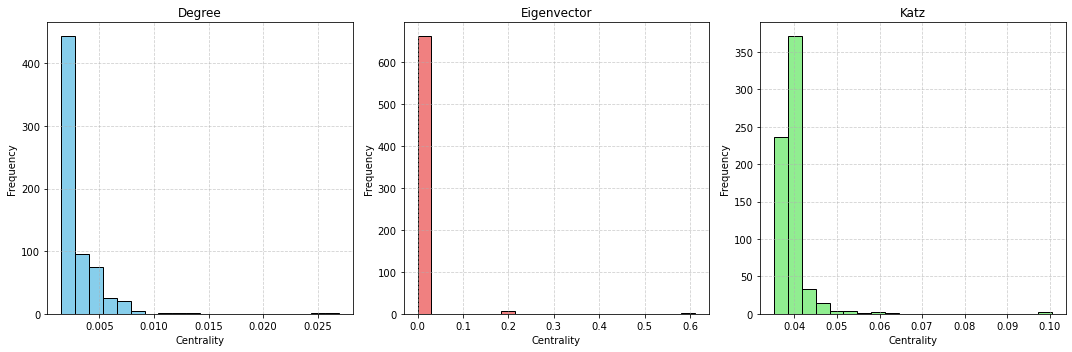

In [30]:
lDegCentrality_ts_youtube, lEigenVectorCentrality_ts_youtube, lKatzCentrality_ts_youtube = compute_centrality(replyGraph_ts_youtube)

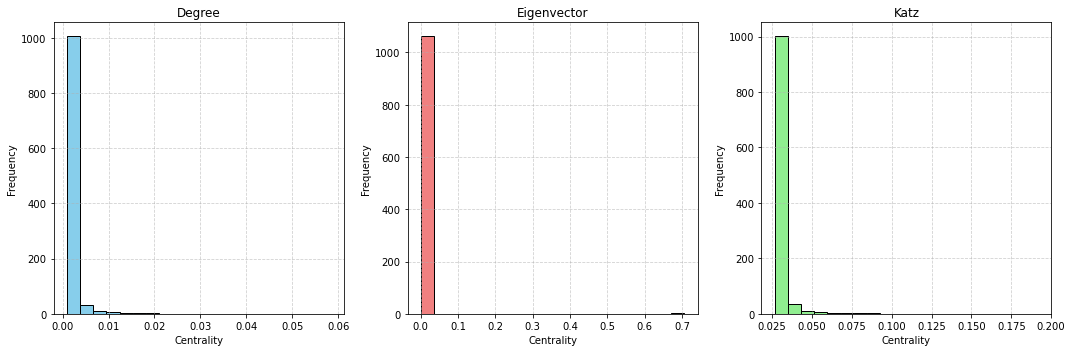

In [31]:
lDegCentrality_bp_youtube, lEigenVectorCentrality_bp_youtube, lKatzCentrality_bp_youtube = compute_centrality(replyGraph_bp_youtube)

### Updating the graph

In [32]:
replyGraph_ts_youtube = update_centrality_attributes(lDegCentrality_ts_youtube, lEigenVectorCentrality_ts_youtube, 
                                                    lKatzCentrality_ts_youtube, replyGraph_ts_youtube, "youtube_ts.graphml")

Global clustering coefficient/transitivit = 0
number of strongly connected components = 669
number of weakly connected components = 213


In [33]:
replyGraph_bp_youtube = update_centrality_attributes(lDegCentrality_bp_youtube, lEigenVectorCentrality_bp_youtube, 
                                                    lKatzCentrality_bp_youtube, replyGraph_bp_youtube, "youtube_bp.graphml")

Global clustering coefficient/transitivit = 0.017857142857142856
number of strongly connected components = 1062
number of weakly connected components = 187


## Louvain Community Detection

In [34]:
replyGraph_ts_youtube = louvaincommunity(replyGraph_ts_youtube, "youtube_ts.graphml", "ground_truth_labels_ts.csv")

CPM purity = 0
Louvain purity = 0.3213751868460389


In [35]:
replyGraph_bp_youtube = louvaincommunity(replyGraph_bp_youtube, "youtube_bp.graphml", "ground_truth_labels_bp.csv")

CPM purity = 0.29411764705882354
Louvain purity = 0.18421052631578946
